# Cole Wins Above Replacement Portfolio (CWARP™) Jupyter Notebook Tutorial

__"Your goal shouldn’t be to buy players. Your goal should be to buy wins."__
__Peter Brand (aka. Paul DePodesta), Moneyball__

What matters in sports is whether a player helps the team win. What matters in investing is whether an asset improves the
risk-adjusted returns of your total portfolio. 

COLE WINS ABOVE REPLACEMENT PORTFOLIO (CWARP)™ is a new metric devised by Artemis Capital Management that measures whether any investment improves the Return to Risk of your Total Portfolio. The CWARP score evaluates the non-linearity and correlation benefits of alternative investments where Sharpe Ratios and other metrics fail. CWARP is quick to calculate while providing a practical assessment of how an investment contributes to portfolio success. Unlike Sharpe Ratios, high CWARP assets are additive, providing a convenient method for allocators to screen investments that improve the portfolio. CWARP™ eliminates investments that "pad" performance statistics with leveraged beta and concave returns. CWARP helps fiduciaries identify hidden gems, true diversifying investments and managers that help the return to risk of your Portfolio. The score offers similar insights derived from complete portfolio optimization, but it is much easier to implement and observe from a tear sheet.

The logic behind CWARP is intuitive in that it answers a simple question: If you borrowed capital to allocate to an alternative investment, does it help or hurt your aggregate portfolio's risk adjusted returns? What allocators will find is that many managers with positive Sharpe Ratios may have negative CWARP scores and vice versa.

__CWARP™ is easy to use and interpret:__

_CWARP™ > 0 means the new asset is improving your portfolio by increasing:_ 
_1) Return to Downside Volatility;_
_2) Return to Maximum Drawdown;_
_3) or BOTH_

_CWARP™ < 0 means the new asset is hurting your portfolio by replicating risk exposures you already own resulting in higher drawdowns and volatility_

The following workbook provides step-by-step examples and code to replicate the CWARP score for and test various portfolios. Yahoo Finance API is used to provide stock data and create the Efficient Frontier. 

Please feel free to use and distribute this workbook and code freely as part of your investment process.  

For full information on the theory and best implementation of CWARP please download the paper on our website.
https://www.artemiscm.com/research-market-views

www.artemiscm.com

_Please see important disclaimers at the end of the notebook._

In [1]:
import pandas as pd 
import numpy as np
from datetime import date

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import yfinance as yf
yf.pdr_override()
import pandas as pd

/usr/local/lib/python3.8/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


__NOTES ON CALCULATION METHODOLOGY__ 

_In academic literature and across professional applications there is widespread disagreement over the proper calculation methodology for the Sharpe, Sortino, and Return to Max Drawdown Ratios. The most common methodology used by most professionals is the arithmetic mean and standard deviation of returns by period multiplied by the square root of the periodicity. Many others will point out that using logarithmic returns is more appropriate, or alternatively using geometric returns in the numerator(e.g. Geometric Sharpe Ratio). In some cases, the volatility calculation will take into account the subtraction of the risk-free rate, and in other cases, this is only applied to the numerator. For the benefit of the doubt, Artemis uses the most common methodology to calculate Sharpe and Sortino Ratios with arithmetic mean and standard deviations. In each respective case, we only subtract the risk-free rate from the numerator. Sortino Ratios assume the zeroing out of positive returns, as opposed to complete elimination, in the downside devation calculation. For the Return to Max Drawdown calculation, we assume the compound annualized growth rate of the asset minus the risk-free rate in the numerator. The maximum drawdown does not take into account the subtraction of the risk-free rate. In the original research paper, risk-free rate and the financing charges are applied by month to each respective return period. In the python code below, a consistent risk-free rate and financing charge is applied to the numerator, as opposed to a variable rate by period._ 

_While calculation methodology will numerically affect each metric slightly, and by proxy the CWARP score, they will not lead to radically different conclusions regarding the relative rankings of assets so long as there is consistency in the technique applied. If you prefer a different methodology, please feel free to edit the accompanying code to fit your preferences._ 

# Traditional Risk to Return Portfolio Metrics
To calculate the CWARP score first we must provide functions for classic risk-reward metrics like the Sharpe Ratio, Sortino Ratio, and Maximum Drawdown

In [2]:
#Risk and Reward Functions##################################################################
def sharpe_ratio(df,risk_free=0,periodicity=252):
    """df - asset return series, e.g. daily returns based on daily close prices of asset
   risk_free - annualized risk free rate (default is assumed to be 0)
   periodicity - number of periods at desired frequency in one year
                e.g. 252 business days in 1 year (default),
                12 months in 1 year,
                52 weeks in 1 year etc."""
    # convert return series to numpy array (in case Pandas series is provided)
    df = np.asarray(df)
    # convert annualized risk free rate into appropriate value for provided frequency of asset return series (df)
    risk_free=(1+risk_free)**(1/periodicity)-1
    # calculate mean excess return based on return series provided
    dfMean=np.nanmean(df)-risk_free
    # calculate standard deviation of return series
    dfSTD=np.nanstd(df)
    # calculate Sharpe Ratio = Mean excess return / Std of returns * sqrt(periodicity)
    dfSharpe=dfMean/dfSTD*np.sqrt(periodicity)
    return dfSharpe

def target_downside_deviation(df, MAR=0, periodicity=252):
    """df - asset return series, e.g. daily returns based on daily close prices of asset
    minimum acceptable return (MAR) - value is subtracted from returns before root-mean-square calculation to obtain target downside deviation (TDD)"""
    # convert return series to numpy array (in case Pandas series is provided)
    df = np.asarray(df)
    # TDD step 1: subtract mininum acceptable return (MAR) from period returns provided in df
    df_ = df - MAR
    # TDD step 2: zero out positive excess returns and calculate root-mean-square for resulting values
    df2 = np.where(df_<0, df_, 0)
    tdd = np.sqrt(np.nanmean(df2**2))
    return tdd

def sortino_ratio(df,risk_free=0, periodicity=252, include_risk_free_in_vol=False):
    """df - asset return series, e.g. daily returns based on daily close prices of asset
   risk_free - annualized risk free rate (default is assumed to be 0). Note: risk free rate is assumed to be the target return/minimum acceptable return (MAR)
               used in calculating both the mean excess return (numerator of Sortino ratio) and determining target downside deviation (TDD, the denominator of Sortino)
   periodicity - number of periods at desired frequency in one year
                e.g. 252 business days in 1 year (default),
                12 months in 1 year,
                52 weeks in 1 year etc."""
    # convert return series to numpy array (in case Pandas series is provided)
    df = np.asarray(df)
    # convert annualized risk free rate into appropriate value for provided frequency of asset return series (df)
    risk_free=(1+risk_free)**(1/periodicity)-1
    # calculate mean excess return based on return series provided
    dfMean=np.nanmean(df)-risk_free
    # calculate target downside deviation (TDD)
    # assume risk free rate is MAR
    if include_risk_free_in_vol==True: MAR=risk_free
    else: MAR=0
    tdd = target_downside_deviation(df, MAR=MAR)
    # calculate Sortino Ratio = Mean excess return / TDD * sqrt(periodicity)
    dfSortino=(dfMean/tdd)*np.sqrt(periodicity)
    return dfSortino

def annualized_return(df,periodicity=252):
    """df - asset return series, e.g. returns based on daily close prices of asset
   periodicity - number of periods at desired frequency in one year
                e.g. 252 business days in 1 year (default),
                12 months in 1 year,
                52 weeks in 1 year etc."""
    # convert return series to numpy array (in case Pandas series is provided)
    df = np.asarray(df)
    # how many years of returns data is provided in df
    difference_in_years = len(df)/periodicity
    # starting net asset value / NAV (assumed to be 1) and cumulative returns (r) over time period provided in returns data
    start_NAV=1.0
    r = np.nancumprod(df+start_NAV)
    # end NAV based on final cumulative return
    end_NAV=r[-1]
    # determine annualized return
    AnnualReturn = end_NAV**(1 / difference_in_years) - 1
    return AnnualReturn

def max_dd(df, return_data=False):
    """df - asset return series, e.g. returns based on daily close prices of asset
    return_data - boolean value to determine if drawdown values over the return data time period should be return, instead of max DD"""
    # convert return series to numpy array (in case Pandas series is provided)
    df = np.asarray(df)
    # calculate cumulative returns
    start_NAV = 1
    r = np.nancumprod(df+start_NAV)
    # calculate cumulative max returns (i.e. keep track of peak cumulative return up to that point in time, despite actual cumulative return at that point in time)
    peak_r = np.maximum.accumulate(r)
    # determine drawdowns relative to peak cumulative return achieved up to each point in time
    dd = (r - peak_r) / peak_r
    # return drawdown values over time period if return_data is set to True, otherwise return max drawdown which will be a positive number
    if return_data==True:
        out = dd
    else:
        out = np.abs(np.nanmin(dd))
    return out

def return_maxdd_ratio(df,risk_free=0,periodicity=252):
    """df - asset return series, e.g. returns based on daily close prices of asset
   risk_free - annualized risk free rate (default is assumed to be 0)
   periodicity - number of periods at desired frequency in one year
                e.g. 252 business days in 1 year (default),
                12 months in 1 year,
                52 weeks in 1 year etc."""
    # convert return series to numpy array (in case Pandas series is provided)
    df = np.asarray(df)
    # convert annualized risk free rate into appropriate value for provided frequency of asset return series (df)
    risk_free=(1+risk_free)**(1/periodicity)-1
    # determine annualized return to be used in numerator of return to max drawdown (RMDD) calculation
    AnnualReturn = annualized_return(df, periodicity=periodicity)
    # determine max drawdown to be used in the denominator of RMDD calculation
    maxDD=max_dd(df,return_data=False)
    return (AnnualReturn-risk_free)/abs(maxDD)

# Coles Win Above Replacement Portfolio (CWARP™) Code:

CWARP begins with the assumption an allocator has a pre-existing or replacement portfolio (60/40 Equity-Bond or Passive Equity). The CWARP score first calculates the 1) Return to Downside Volatility (Sortino Ratio) and 2) Return to Maximum Drawdown of
the ”replacement” portfolio. CWARP assumes the allocator borrows cash to layer an alternative investment on top of the replacement portfolio. CWARP recalculates the Return to Downside Volatility and Return to the Maximum Drawdown for the revised portfolio. CWARP is then calculated by taking the geometric average of the ratio between the Sortino Ratio and Return to Maximum Drawdown of the new and replacement portfolios.The CWARP shares inputs with the Sharpe Ratio, including manager returns, volatility, and the risk-free rate. Several new inputs include the returns of the replacement/base portfolio, financing rate, and the percentage allocation for the new investment. The standardized CWARP score uses a 60/40 portfolio or Equity Beta as the replacement strategy and a 25% weighting. If an asset can be portfolio margined without added cash (e.g., derivative-overlays), it may be appropriate to reduce financing charges to 0%.

In [3]:
def cole_win_above_replace_port(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    """Cole Win Above Replacement Portolio (CWARP): Total score to evaluate whether any new investment improves or hurts the return to risk of your total portfolio.
    new_asset = returns of the asset you are thinking of adding to your portfolio
    replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    risk_free_rate = Tbill rate (annualized)
    financing_rate = portfolio margin/borrowing cost (annualized) to layer new asset on top of prevailing portfolio (e.g. LIBOR + 60bps). No financing rate is reasonable for derivate overlay products. 
    weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count"""
    # convert annualized financing rate into appropriate value for provided periodicity
    # risk_free_rate will be converted appropriately in respective Sortino and RMDD calcs
    financing_rate=(1+financing_rate)**(1/periodicity)-1

    #Calculate Replacement Portfolio Sortino Ratio
    replace_port_sortino = sortino_ratio(replace_port, risk_free=risk_free_rate, periodicity=periodicity)

    #Calculate Replacement Portfolio Return to Max Drawdown
    replace_port_return_maxdd = return_maxdd_ratio(replace_port, risk_free=risk_free_rate, periodicity=periodicity)

    #Calculate New Portfolio Sortino Ratio
    new_port = (new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port
    new_port_sortino = sortino_ratio(new_port, risk_free=risk_free_rate, periodicity=periodicity)

    #Calculate New Portfolio Return to Max Drawdown
    new_port_return_maxdd = return_maxdd_ratio(new_port, risk_free=risk_free_rate, periodicity=periodicity)

    #Final CWARP calculation
    CWARP = ((new_port_return_maxdd/replace_port_return_maxdd*new_port_sortino/replace_port_sortino)**(1/2)-1)*100

    return CWARP

def cwarp_additive_sortino(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    """Cole Win Above Replacement Portolio (CWARP) Sortino +: Isolates new investment effect on total portfolio Sortino Ratio, which is a portion of the holistic CWARP score.
    new_asset = returns of the asset you are thinking of adding to your portfolio
    replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    risk_free_rate = Tbill rate (annualized)
    financing_rate = portfolio margin/borrowing cost (annualized) to layer new asset on top of prevailing portfolio (e.g. LIBOR + 60bps). No financing rate is reasonable for derivate overlay products. 
    weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count"""
    # convert annualized financing rate into appropriate value for provided periodicity
    # risk_free_rate will be converted appropriately in respective Sortino and RMDD calcs
    financing_rate=(1+financing_rate)**(1/periodicity)-1

    #Calculate Replacement Portfolio Sortino Ratio
    replace_port_sortino = sortino_ratio(replace_port, risk_free=risk_free_rate, periodicity=periodicity)

    #Calculate New Portfolio Sortino Ratio
    new_port = (new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port
    new_port_sortino = sortino_ratio(new_port, risk_free=risk_free_rate, periodicity=periodicity)

    #Final calculation
    CWARP_add_sortino=((new_port_sortino/replace_port_sortino)-1)*100

    return CWARP_add_sortino

def cwarp_additive_ret_maxdd(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    """Cole Win Above Replacement Portolio (CWARP) Ret to Max DD +: Isolates new investment effect on total portfolio Return to MAXDD, which is a portion of the holistic CWARP score.
    new_asset = returns of the asset you are thinking of adding to your portfolio
    replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    risk_free_rate = Tbill rate (annualized)
    financing_rate = portfolio margin/borrowing cost (annualized) to layer new asset on top of prevailing portfolio (e.g. LIBOR + 60bps). No financing rate is reasonable for derivate overlay products. 
    weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count"""
    # convert annualized financing rate into appropriate value for provided periodicity
    # risk_free_rate will be converted appropriately in respective Sortino and RMDD calcs
    financing_rate=(1+financing_rate)**(1/periodicity)-1

    #Calculate Replacement Portfolio Return to Max Drawdown
    replace_port_return_maxdd = return_maxdd_ratio(replace_port, risk_free=risk_free_rate, periodicity=periodicity)

    #Calculate New Portfolio Return to Max Drawdown
    new_port = (new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port
    new_port_return_maxdd = return_maxdd_ratio(new_port, risk_free=risk_free_rate, periodicity=periodicity)

    #Final calculation
    CWARP_add_ret_maxdd=((new_port_return_maxdd/replace_port_return_maxdd)-1)*100

    return CWARP_add_ret_maxdd

def cwarp_port_return(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    """Cole Win Above Replacement Portolio (CWARP) Portfolio Return: Returns of the aggregate portfolio after a new asset is financed and layered on top of the replacement portfolio. 
    new_asset = returns of the asset you are thinking of adding to your portfolio
    replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    risk_free_rate = Tbill rate (annualized)
    financing_rate = portfolio margin/borrowing cost (annualized) to layer new asset on top of prevailing portfolio (e.g. LIBOR + 60bps). No financing rate is reasonable for derivate overlay products. 
    weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count"""
    # convert annual financing based on periodicity
    financing_rate=((financing_rate+1)**(1/periodicity)-1)

    # compose new portfolio
    new_port=(new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port
    
    # calculate annualized return of new portfolio and subtract risk-free rate
    out = annualized_return(new_port, periodicity=periodicity) - risk_free_rate
    return out

def cwarp_port_risk(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    """Cole Win Above Replacement Portolio (CWARP) Portfolio Risk: Volatility of the aggregate portfolio after a new asset is financed and layered on top of the replacement portfolio. 
    new_asset = returns of the asset you are thinking of adding to your portfolio
    replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    risk_free_rate = Tbill rate (annualized)
    financing_rate = portfolio margin/borrowing cost (annualized) to layer new asset on top of prevailing portfolio (e.g. LIBOR + 60bps). No financing rate is reasonable for derivate overlay products. 
    weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count"""
    # convert annual financing and risk free rates based on periodicity
    financing_rate=((financing_rate+1)**(1/periodicity)-1)
    risk_free_rate=((risk_free_rate+1)**(1/periodicity)-1)
    # compose new portfolio
    new_port=(new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port
    # calculated target downside deviation (TDD)
    tdd = target_downside_deviation(new_port, MAR=0)*np.sqrt(periodicity)
    return tdd

def cwarp_new_port_data(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    """Cole Win Above Replacement Portolio (CWARP) return stream: Return series after a new asset is financed and layered on top of the replacement portfolio. 
    new_asset = returns of the asset you are thinking of adding to your portfolio
    replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    risk_free_rate = Tbill rate 
    financing_rate = portfolio margin/borrowing cost to layer new asset on top of prevailing portfolio (e.g. LIBOR + 60bps). No financing rate is reasonable for derivate overlay products. 
    weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count"""
    # convert annual financing based on periodicity
    financing_rate=((financing_rate+1)**(1/periodicity)-1)
    new_port=(new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port
    return new_port

Data function to pull yahoo finance time series

In [4]:
def retrieve_yhoo_data(ticker='spy', start_date='2007-07-01', end_date='2020-12-31'):
    data_hold=yf.Ticker(ticker)
    price_df=data_hold.history(start=start_date,  end=end_date).Close.pct_change()
    price_df.name=ticker
    return price_df

Simple example of implementing CWARP Score for GLD (SPDR Gold Trust) as a diversifer on a 60/40 Stock-to-Bond portfolio

In [5]:
cole_win_above_replace_port(new_asset=retrieve_yhoo_data('gld'),replace_port=retrieve_yhoo_data('spy')*.60+retrieve_yhoo_data('ief')*.40
                            ,risk_free_rate=.005,financing_rate=0.01,weight_asset=0.25,weight_replace_port=1,periodicity=252)

19.862679839852525

# Discover Assets that Improve your Total Portfolio Risk-Adjusted Returns
The code below references a 60% Stocks/40% Bonds as the replacement portfolio, and then iterates a wide range of portfolio diversifiers to calculate potential Efficient Frontiers

In [6]:
# set up parameters for comparing various additions to a base replacement portfolio composed of 60/40 stock-bond portfolio
# however, this may be modified to evaluate for any replacement portfolio of choice
start_date='2007-07-01'
end_date='2020-12-31'
ticker_list=['qqq','lqd','hyg','tlt','ief','shy','gld','slv','efa','eem','iyr','xle','xlk','xlf']
replacement_port_tik=['spy','ief']
replacement_port_w=[0.6,0.4]
replacement_port=sum([retrieve_yhoo_data(sym, start_date, end_date)*replacement_port_w[i] for i, sym in enumerate(replacement_port_tik)])
replacement_port_name='Classic 60/40'
replacement_port.name=replacement_port_name
financing_rate=.01
risk_free_rate=0.005
weight_asset=0.25
weight_replace_port=1
periodicity=252

In [7]:
# Formatting to set up two tables below
# Table 1 (risk_ret_df): Evaluate Sharpe, Sortino, Max DD etc for various indices/assets/tickers and CWARP/CWARP components when added at 25% weighting as a layer on top of replacement portfolio
# Table 2 (new_risk_ret_df): Evaluate the new portfolio's (when each asset added as 25% weighting as a layer on top of replacement portfolio) Return, Downside Vol, Sharpe, Sortino, Max DD, RMDD, CWARP
percentage_weight_asset = "{:.0%}".format(weight_asset)
percentage_weight_replace_port = "{:.0%}".format(weight_replace_port)
CWARP_W_String=str('CWARP_'+percentage_weight_asset+'_asset')

risk_ret_df=pd.DataFrame(index=['Start_Date','End_Date','CWARP','+Sortino','+Ret_To_MaxDD','Sharpe','Sortino','Max_DD'],columns=ticker_list)
new_risk_ret_df=pd.DataFrame(index=['Return','Vol','Sharpe','Sortino','Max_DD','Ret_To_MaxDD','CWARP_25%_asset'],columns=ticker_list)
new_risk_ret_df=new_risk_ret_df.add_suffix('@'+percentage_weight_asset+' | '+replacement_port.name+'@'+percentage_weight_replace_port)
new_risk_ret_df[replacement_port.name]=np.nan

prices_df=pd.DataFrame(index=retrieve_yhoo_data(ticker_list[0]).index)   

# evaluate metrics for all tickers in list above
for i in range(0,len(ticker_list)):
    temp_data=retrieve_yhoo_data(ticker_list[i])
    new_port = cwarp_new_port_data(new_asset=temp_data,replace_port=replacement_port,financing_rate=financing_rate,
                                   risk_free_rate=risk_free_rate,weight_asset=weight_asset,weight_replace_port=weight_replace_port,periodicity=periodicity)
    prices_df=pd.merge(prices_df,temp_data, left_index=True, right_index=True)
    risk_ret_df.loc['Start_Date',ticker_list[i]]=min(temp_data.index)
    risk_ret_df.loc['End_Date',ticker_list[i]]=max(temp_data.index)
    
    risk_ret_df.loc['CWARP',ticker_list[i]]=cole_win_above_replace_port(new_asset=temp_data,replace_port=replacement_port,financing_rate=financing_rate,
                                                                        risk_free_rate=risk_free_rate,weight_asset=weight_asset,weight_replace_port=weight_replace_port,periodicity=periodicity)
    
    risk_ret_df.loc['+Sortino',ticker_list[i]]=cwarp_additive_sortino(new_asset=temp_data,replace_port=replacement_port,financing_rate=financing_rate,
                                                                        risk_free_rate=risk_free_rate,weight_asset=weight_asset,weight_replace_port=weight_replace_port,periodicity=periodicity)
    
    risk_ret_df.loc['+Ret_To_MaxDD',ticker_list[i]]=cwarp_additive_ret_maxdd(new_asset=temp_data,replace_port=replacement_port,financing_rate=financing_rate,
                                                                        risk_free_rate=risk_free_rate,weight_asset=weight_asset,weight_replace_port=weight_replace_port,periodicity=periodicity)
    risk_ret_df.loc['Sharpe',ticker_list[i]]=sharpe_ratio(temp_data,risk_free=risk_free_rate, periodicity=periodicity)
    risk_ret_df.loc['Sortino',ticker_list[i]]=sortino_ratio(temp_data,risk_free=risk_free_rate, periodicity=periodicity)
    risk_ret_df.loc['Max_DD',ticker_list[i]]=max_dd(temp_data)
    
    new_risk_ret_df.loc['Return',new_risk_ret_df.columns[i]]=cwarp_port_return(new_asset=temp_data,replace_port=replacement_port,financing_rate=financing_rate,
                                                                        risk_free_rate=risk_free_rate,weight_asset=weight_asset,weight_replace_port=weight_replace_port,periodicity=periodicity)
    
    new_risk_ret_df.loc['Vol',new_risk_ret_df.columns[i]]=cwarp_port_risk(new_asset=temp_data,replace_port=replacement_port,financing_rate=financing_rate,
                                                                        risk_free_rate=risk_free_rate,weight_asset=weight_asset,weight_replace_port=weight_replace_port,periodicity=periodicity)
    
    new_risk_ret_df.loc['Sharpe',new_risk_ret_df.columns[i]]=sharpe_ratio(new_port, risk_free=risk_free_rate, periodicity=periodicity)
                                                                          
    new_risk_ret_df.loc['Sortino',new_risk_ret_df.columns[i]]=sortino_ratio(new_port, risk_free=risk_free_rate, periodicity=periodicity)
    
    new_risk_ret_df.loc['Max_DD',new_risk_ret_df.columns[i]]=max_dd(new_port)
    
    new_risk_ret_df.loc['Ret_To_MaxDD',new_risk_ret_df.columns[i]]=return_maxdd_ratio(new_port, risk_free=risk_free_rate, periodicity=periodicity)
    
    new_risk_ret_df.loc[CWARP_W_String,new_risk_ret_df.columns[i]]=risk_ret_df.loc['CWARP',ticker_list[i]]
    
new_risk_ret_df.loc['Return',[replacement_port_name]]=annualized_return(replacement_port, periodicity=periodicity)
new_risk_ret_df.loc['Vol',[replacement_port_name]]=target_downside_deviation(replacement_port, MAR=0)*np.sqrt(periodicity)
new_risk_ret_df.loc['Sharpe',[replacement_port_name]]=sharpe_ratio(replacement_port, risk_free=risk_free_rate, periodicity=periodicity)
new_risk_ret_df.loc['Sortino',[replacement_port_name]]=sortino_ratio(replacement_port, risk_free=risk_free_rate, periodicity=periodicity)
new_risk_ret_df.loc['Max_DD',[replacement_port_name]]=max_dd(replacement_port)
new_risk_ret_df.loc['Ret_To_MaxDD',[replacement_port_name]]=return_maxdd_ratio(replacement_port, risk_free=risk_free_rate, periodicity=periodicity)
new_risk_ret_df.loc[CWARP_W_String, [replacement_port_name]]=cole_win_above_replace_port(new_asset=replacement_port, replace_port=replacement_port, risk_free_rate=risk_free_rate, financing_rate=financing_rate, 
                            weight_asset=weight_asset, weight_replace_port=weight_replace_port, periodicity=periodicity)
first_col = new_risk_ret_df.pop(replacement_port_name)
new_risk_ret_df.insert(0, replacement_port_name, first_col)

First we evaluate each individual asset by CWARP score to see if it is helping the risk-adjusted returns of a 60/40 portfolio. We compare that data to outdated performance metrics like Sharpe and Sortino.

In [8]:
risk_ret_df.sort_values(by='CWARP', axis=1, ascending=False)

,tlt,ief,gld,lqd,shy,qqq,xlk,slv,hyg,iyr,eem,efa,xle,xlf
Start_Date,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00
End_Date,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00
CWARP,35.075059,21.355028,19.86268,10.370056,4.964182,3.054918,0.176191,-3.105972,-5.412795,-23.615039,-24.563182,-27.322877,-33.078864,-33.273558
+Sortino,29.874918,18.216353,13.873923,9.440441,3.734666,2.767763,-0.26814,-6.900377,-3.632828,-21.710574,-24.392485,-24.57957,-34.119457,-27.888017
+Ret_To_MaxDD,40.483412,24.577036,26.166392,11.307567,6.208272,3.342876,0.622501,0.84308,-7.159884,-25.473176,-24.733494,-29.9664,-32.021834,-38.256891
Sharpe,0.544866,0.746821,0.473668,0.663613,1.049695,0.751663,0.684662,0.302802,0.464621,0.28593,0.239333,0.192215,0.091022,0.211968
Sortino,0.790751,1.100768,0.672288,0.942979,1.615862,1.065266,0.973925,0.414236,0.669127,0.405208,0.344397,0.266824,0.126671,0.306036
Max_DD,0.265854,0.104014,0.45555,0.217621,0.022314,0.53404,0.530358,0.762802,0.342465,0.705002,0.664343,0.610373,0.712628,0.822147


Next we calculate the metrics of the brand new portfolios with the new asset layered on top at 25%. This is the raw data we can use to construct and Efficient Frontier

In [9]:
new_risk_ret_df.sort_values(by='Sharpe', axis=1, ascending=False)

,tlt@25% | Classic 60/40@100%,ief@25% | Classic 60/40@100%,gld@25% | Classic 60/40@100%,lqd@25% | Classic 60/40@100%,shy@25% | Classic 60/40@100%,qqq@25% | Classic 60/40@100%,Classic 60/40,xlk@25% | Classic 60/40@100%,hyg@25% | Classic 60/40@100%,slv@25% | Classic 60/40@100%,iyr@25% | Classic 60/40@100%,efa@25% | Classic 60/40@100%,eem@25% | Classic 60/40@100%,xlf@25% | Classic 60/40@100%,xle@25% | Classic 60/40@100%
Return,0.100618,0.091829,0.099673,0.093002,0.081617,0.115787,0.084037,0.112338,0.089942,0.098068,0.091202,0.081532,0.086401,0.084476,0.074215
Vol,0.077024,0.078078,0.088729,0.086457,0.080336,0.117915,0.081088,0.118684,0.097239,0.111243,0.130806,0.120742,0.129702,0.135409,0.132069
Sharpe,0.909868,0.831409,0.806098,0.777532,0.73672,0.733642,0.711829,0.710859,0.690471,0.676461,0.561602,0.542909,0.537379,0.515902,0.477671
Sortino,1.32049,1.201953,1.157802,1.112725,1.054712,1.044881,1.016740,1.014014,0.979803,0.946581,0.796,0.76683,0.768732,0.733191,0.669834
Max_DD,0.280871,0.290371,0.309944,0.328926,0.304665,0.436661,0.313935,0.435658,0.382038,0.38183,0.482234,0.46158,0.453658,0.541374,0.435315
Ret_To_MaxDD,0.375968,0.333399,0.337652,0.297886,0.284239,0.276571,0.267624,0.26929,0.248463,0.269881,0.199452,0.187427,0.201432,0.16524,0.181926
CWARP_25%_asset,35.075059,21.355028,19.86268,10.370056,4.964182,3.054918,-1.407647,0.176191,-5.412795,-3.105972,-23.615039,-27.322877,-24.563182,-33.273558,-33.078864


Lastly, we plot the portfolios to visualize how high CWARP assets push your portfolio further out on the Efficient Frontier of Return and Risk.

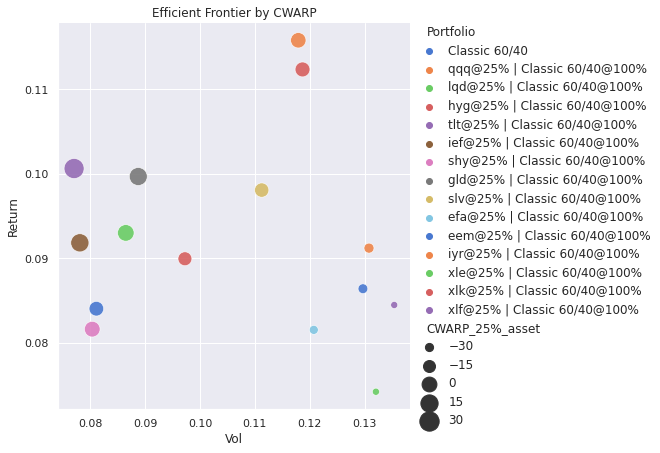

In [10]:
import seaborn as sns
sns.set_theme(style="white")
sns.set(rc={'figure.figsize':(125,10)})

#Load Data
adjust_new_risk = new_risk_ret_df.transpose()
adjust_new_risk['Portfolio']=adjust_new_risk.index

#Plot Seaborn
ax=sns.relplot(x="Vol", y="Return", hue="Portfolio", size=CWARP_W_String,
            sizes=(50, 400), alpha=.9, palette="muted",
            height=6, data=adjust_new_risk)
plt.title('Efficient Frontier by CWARP');

__DISCLAIMER:__ 

_THIS RESEARCH IS BEING PROVIDED FOR INFORMATIONAL PURPOSES ONLY AND SHOULD NOT BE CONSTRUED IN ANY WAY AS A SOLICITATION FOR ANY ARTEMIS FUND, STRATEGY, OR INVESTMENT PRODUCT. NONE OF THE DATA PRESENTED HEREIN REPRESENTS REAL OR HYPOTHETICAL RETURNS ACHIEVED BY ANY STRATEGIES OR INVESTMENT VEHICLES OF ARTEMIS CAPITAL MANAGEMENT LP, ARTEMIS CAPITAL ADVISERS LP, OR ITS AFFILIATES. THIS IS NOT AN OFFERING OR THE SOLICITATION OF AN OFFER TO PURCHASE AN INTEREST IN ANY STRATEGIES OR INVESTMENT VEHICLES OF ARTEMIS CAPITAL MANAGEMENT LP OR ARTEMIS CAPITAL ADVISERS LP. ANY SUCH OFFER OR SOLICITATION WILL ONLY BE MADE TO QUALIFIED INVESTORS BY MEANS OF A CONFIDENTIAL PRIVATE PLACEMENT MEMORANDUM (THE "MEMORANDUM") AND ONLY IN THOSE JURISDICTIONS WHERE PERMITTED BY LAW.
AN INVESTMENT SHOULD ONLY BE MADE AFTER CAREFUL REVIEW OF A FUND'S MEMORANDUM. AN INVESTMENT IN A FUND IS SPECULATIVE AND INVOLVES A HIGH DEGREE OF RISK. OPPORTUNITIES FOR WITHDRAWAL, REDEMPTION, AND TRANSFERABILITY OF INTERESTS ARE RESTRICTED, SO INVESTORS MAY NOT HAVE ACCESS TO CAPITAL WHEN IT IS NEEDED. THERE IS NO SECONDARY MARKET FOR THE INTERESTS, AND NONE IS EXPECTED TO DEVELOP. NO ASSURANCE CAN BE GIVEN THAT THE INVESTMENT OBJECTIVE WILL BE ACHIEVED OR THAT AN INVESTOR WILL RECEIVE A RETURN
OF ALL OR ANY PORTION OF HIS OR HER INVESTMENT IN A FUND. INVESTMENT RESULTS MAY VARY SUBSTANTIALLY OVER ANY GIVEN TIME PERIOD. CERTAIN DATA CONTAINED HEREIN IS BASED ON INFORMATION OBTAINED FROM SOURCES BELIEVED TO BE ACCURATE, BUT WE CANNOT GUARANTEE THE ACCURACY OF SUCH INFORMATION. ANY AND ALL CONTENTS OF THIS RESEARCH  ARE FOR INFORMATIONAL PURPOSES ONLY. NEITHER THE INFORMATION PROVIDED HEREIN NOR THE PROGRAMMING AND QUANTITATIVE REFERENCE MATERIALS PROVIDED SHOULD BE CONSTRUED AS A GUARANTEE OF ANY PORTFOLIO PERFORMANCE USING CWARP OR ANY OTHER METRIC DEVELOPED OR DISCUSSED HEREIN. ANY INDIVIDUAL WHO USES, REFERENCES OR OTHERWISE ACCESSES THIS PAPER, THE GITHUB REPOSITORY, THE WEB-APP FOR CWARP EXPERIMENTATION OR ANY OTHER DATA, THEORY, FORMULA, OR ANY OTHER INFORMATION CREATED, USED, OR REFERENCED BY ARTEMIS DOES SO AT THEIR OWN RISK AND, BY ACCESSING ANY SUCH INFORMATION, INDEMNIFIES AND HOLDS HARMLESS ARTEMIS CAPITAL MANAGEMENT LP, ARTEMIS CAPITAL ADVISERS LP, AND ALL OF ITS AFFILIATES (TOGETHER, "ARTEMIS") AGAINST ANY LOSS OF CAPITAL THEY MAY OR MAY NOT INCUR BY UTILIZING SUCH DATA. ARTEMIS DOES NOT BEAR ANY RESPONSIBILITY FOR THEOUTCOME OF ANY PORTFOLIO NOT DIRECTLY OWNED AND/OR MANAGED BY ARTEMIS._